In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import src.resnet.utils as utils


data = utils.import_csv()
train_data, val_data = utils.split_data(data=data)

In [18]:
len(train_data)

2606

In [4]:
from src.resnet.dataloader.mygo_dataloader import dataset_transform, data_loader
train_data_transformed = dataset_transform(data=train_data, mode="train")
val_data_transformed = dataset_transform(data=val_data, mode="val")
train_loader = data_loader(tranformed_dataset=train_data_transformed, batch_size=16, num_workers=1, shuffle=True)
val_loader = data_loader(tranformed_dataset=val_data_transformed, batch_size=16, num_workers=1, shuffle=True)

In [5]:
len(train_loader)



163

In [6]:
len(val_loader)

41

16 16
torch.Size([16, 3, 224, 224])


Text(0.5, 1.0, '5')

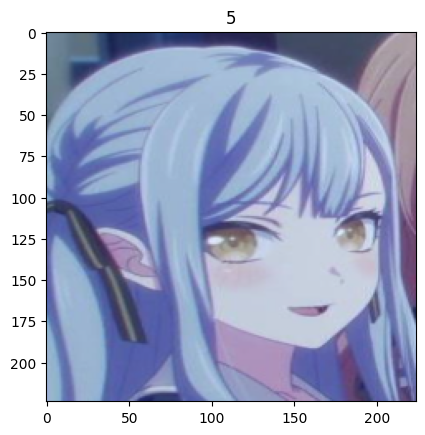

In [7]:
import matplotlib.pyplot as plt
import numpy as np
idx = 8
data, labels = next(iter(val_loader))
print(len(labels), len(data))
print(data.shape)
image_np = data[idx].numpy().transpose((1,2,0))
image_np = image_np * 0.229 + 0.485  # Undo normalization (normalize values back to the original range)

# If the image looks too dark due to normalization, try scaling it
image_np = np.clip(image_np, 0, 1) 

plt.imshow(image_np)
plt.title(labels[idx])

In [8]:
labels

('0',
 '8',
 '4',
 '0',
 '1',
 '1',
 '0',
 '2',
 '5',
 '1',
 '10',
 '2',
 '3',
 '0',
 '10',
 '6')

In [9]:
type(data)

torch.Tensor

In [10]:
from src.resnet.resnet_model.mygo_model import ResNet50
import torch.nn as nn
import torch

torch.manual_seed(32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = ResNet50(input_channel=3).to(device)
from timeit import default_timer as timer

# Import tqdm for progress bar
from tqdm.auto import tqdm
from torchmetrics import Accuracy
def accuracy_fn(y_pred,y_true):
    # Get the predicted class by finding the index with the maximum value
    y_pred_class = torch.argmax(y_pred)
    
    # Check how many predictions are correct
    correct_predictions = torch.eq(y_pred_class, y_true).sum().item()
    
    # Calculate the accuracy
    accuracy = (correct_predictions / len(y_true)) * 100
    
    return accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model_resnet.parameters(),
                            lr=0.01)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
epochs = 10
all_labels = []
all_preds = []
time_start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch = {epoch+1}\n-------------")
    train_loss = 0
    train_acc = 0
    model_resnet.train()
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)          
        y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
        y_logits = model_resnet(X)
        y_logits = y_logits - torch.max(y_logits).item()
        y_pred = torch.argmax(y_logits,dim=1)
        #calculate loss and costfunction
        acc = accuracy_fn(y_pred=y_pred,y_true=y)
        loss = loss_fn(y_logits,y)
        train_loss += loss.item()
        train_acc += acc

        #grad to zero
        optimizer.zero_grad()

        #backpropagation
        loss.backward()

        #gradient descent
        optimizer.step()
        if(batch%20 == 0):
            print(f"loss: {loss.item():.5f} ,ACC: {acc:.2f}\n")
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_loader)

    #val dataset
    val_loss = 0
    val_acc = 0
    for batch, (X_val_batch, y_val) in enumerate(val_loader):
        X_val_batch = X_val_batch.to(device)
        y_val = torch.tensor([int(label) for label in y_val], dtype=torch.long, device=device)
        model_resnet.eval()
        with torch.inference_mode():
            y_val_logits = model_resnet(X_val_batch)
            y_val_logits = y_val_logits - torch.max(y_val_logits).item()
            y_val_pred = torch.argmax(y_val_logits,dim=1)
            loss = loss_fn(y_val_logits,y_val)
            acc = accuracy_fn(y_val_pred,y_val)
            val_loss += loss.item()
            val_acc += acc
    val_loss /=len(val_loader)
    val_acc /=len(val_loader)
    
    print(f"Train loss: {train_loss:.5f} ,Train acc: {train_acc:.2f}\n Val loss: {val_loss:.5f}, Val acc: {val_acc:.2f}\n")
time_end = timer()
duration = time_end-time_start
print(f"time use:{(duration):2f}seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch = 1
-------------
loss: 2.38856 ,ACC: 31.25

loss: 2.68773 ,ACC: 18.75

loss: 2.33355 ,ACC: 6.25

loss: 2.32763 ,ACC: 6.25

loss: 2.34786 ,ACC: 12.50

loss: 2.34009 ,ACC: 18.75

loss: 2.18148 ,ACC: 31.25

loss: 2.24168 ,ACC: 6.25

loss: 2.20659 ,ACC: 18.75



 10%|█         | 1/10 [00:19<02:59, 19.98s/it]

Train loss: 6.60038 ,Train acc: 11.78
 Val loss: 2.27482, Val acc: 14.79

Epoch = 2
-------------
loss: 2.34645 ,ACC: 12.50

loss: 2.26539 ,ACC: 6.25

loss: 2.14838 ,ACC: 6.25

loss: 2.15900 ,ACC: 18.75

loss: 2.51369 ,ACC: 12.50

loss: 2.17256 ,ACC: 18.75

loss: 2.31738 ,ACC: 12.50

loss: 2.30148 ,ACC: 6.25

loss: 2.29348 ,ACC: 6.25



 20%|██        | 2/10 [00:38<02:34, 19.34s/it]

Train loss: 2.30881 ,Train acc: 11.66
 Val loss: 2.27722, Val acc: 14.68

Epoch = 3
-------------
loss: 2.32851 ,ACC: 18.75

loss: 2.35727 ,ACC: 12.50

loss: 2.22277 ,ACC: 6.25

loss: 2.40989 ,ACC: 0.00

loss: 2.58760 ,ACC: 18.75

loss: 2.28164 ,ACC: 12.50

loss: 2.41817 ,ACC: 0.00

loss: 2.26212 ,ACC: 31.25

loss: 2.29673 ,ACC: 6.25



 30%|███       | 3/10 [00:57<02:13, 19.06s/it]

Train loss: 2.30986 ,Train acc: 11.66
 Val loss: 2.27989, Val acc: 14.68

Epoch = 4
-------------
loss: 2.23174 ,ACC: 6.25

loss: 2.28188 ,ACC: 0.00

loss: 2.61391 ,ACC: 0.00

loss: 2.42816 ,ACC: 25.00

loss: 2.55457 ,ACC: 0.00

loss: 2.29708 ,ACC: 0.00

loss: 2.56573 ,ACC: 12.50

loss: 2.38302 ,ACC: 6.25

loss: 2.37969 ,ACC: 6.25



 40%|████      | 4/10 [01:16<01:55, 19.17s/it]

Train loss: 2.30846 ,Train acc: 11.66
 Val loss: 2.27280, Val acc: 14.79

Epoch = 5
-------------
loss: 2.39343 ,ACC: 6.25

loss: 2.21639 ,ACC: 6.25

loss: 2.19360 ,ACC: 12.50

loss: 2.45538 ,ACC: 6.25

loss: 2.28585 ,ACC: 25.00

loss: 2.16206 ,ACC: 6.25

loss: 2.24620 ,ACC: 12.50

loss: 2.38346 ,ACC: 6.25

loss: 2.27085 ,ACC: 18.75



 50%|█████     | 5/10 [01:34<01:32, 18.58s/it]

Train loss: 2.30991 ,Train acc: 11.66
 Val loss: 2.27357, Val acc: 14.74

Epoch = 6
-------------
loss: 2.31628 ,ACC: 0.00

loss: 2.28274 ,ACC: 18.75

loss: 2.31169 ,ACC: 12.50

loss: 2.29632 ,ACC: 12.50

loss: 2.54611 ,ACC: 18.75

loss: 2.44145 ,ACC: 6.25

loss: 2.29677 ,ACC: 12.50

loss: 2.32095 ,ACC: 12.50

loss: 2.15262 ,ACC: 12.50



 60%|██████    | 6/10 [01:51<01:12, 18.10s/it]

Train loss: 2.30738 ,Train acc: 11.66
 Val loss: 2.27919, Val acc: 14.74

Epoch = 7
-------------
loss: 2.35117 ,ACC: 6.25

loss: 2.18225 ,ACC: 6.25

loss: 2.12009 ,ACC: 12.50

loss: 2.49840 ,ACC: 12.50

loss: 2.42817 ,ACC: 18.75

loss: 2.31512 ,ACC: 25.00

loss: 2.21337 ,ACC: 18.75

loss: 2.32902 ,ACC: 0.00

loss: 2.50955 ,ACC: 18.75



 70%|███████   | 7/10 [02:08<00:53, 17.82s/it]

Train loss: 2.30982 ,Train acc: 11.66
 Val loss: 2.28669, Val acc: 14.74

Epoch = 8
-------------
loss: 2.11369 ,ACC: 0.00

loss: 2.19806 ,ACC: 12.50

loss: 2.43092 ,ACC: 0.00

loss: 2.32049 ,ACC: 6.25

loss: 2.40357 ,ACC: 37.50

loss: 2.43859 ,ACC: 18.75

loss: 2.36669 ,ACC: 25.00

loss: 2.47147 ,ACC: 6.25

loss: 2.25747 ,ACC: 6.25



 80%|████████  | 8/10 [02:25<00:35, 17.59s/it]

Train loss: 2.30980 ,Train acc: 11.66
 Val loss: 2.26918, Val acc: 14.68

Epoch = 9
-------------
loss: 2.31312 ,ACC: 6.25

loss: 2.21811 ,ACC: 18.75

loss: 2.32800 ,ACC: 6.25

loss: 2.44748 ,ACC: 18.75

loss: 2.48928 ,ACC: 6.25

loss: 2.26344 ,ACC: 0.00

loss: 2.22769 ,ACC: 12.50

loss: 2.19082 ,ACC: 31.25

loss: 2.18685 ,ACC: 6.25



 90%|█████████ | 9/10 [02:43<00:17, 17.49s/it]

Train loss: 2.30854 ,Train acc: 11.66
 Val loss: 2.26862, Val acc: 14.68

Epoch = 10
-------------
loss: 2.22947 ,ACC: 25.00

loss: 2.20203 ,ACC: 18.75

loss: 2.22503 ,ACC: 6.25

loss: 2.29025 ,ACC: 6.25

loss: 2.33046 ,ACC: 25.00

loss: 2.16442 ,ACC: 18.75

loss: 2.28689 ,ACC: 18.75

loss: 2.34503 ,ACC: 6.25

loss: 2.17116 ,ACC: 6.25



100%|██████████| 10/10 [03:00<00:00, 18.05s/it]

Train loss: 2.30993 ,Train acc: 11.66
 Val loss: 2.27316, Val acc: 14.68

time use:180.455609seconds


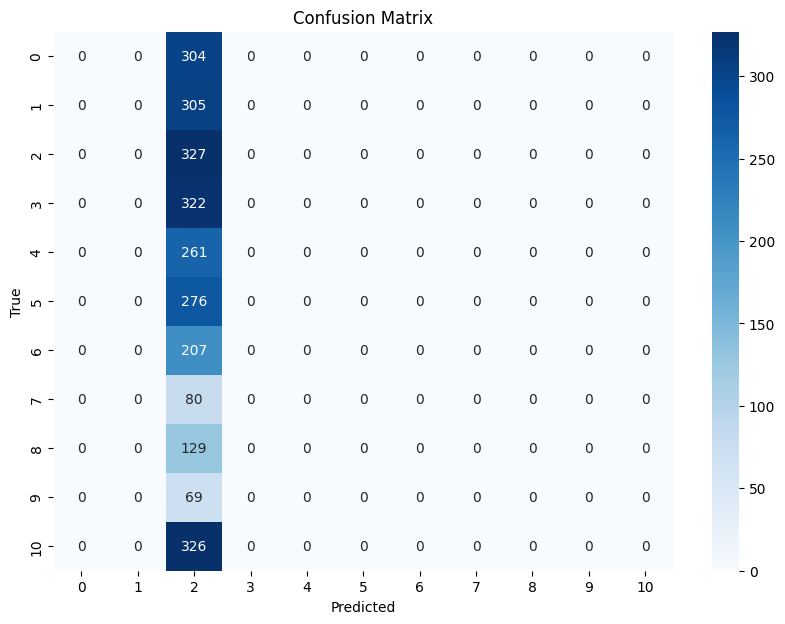

In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lists to store all true labels and predictions
all_labels = []
all_preds = []

# Iterate over the batches
for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
    
    # Get predictions
    with torch.no_grad():
        y_pred = model_resnet(X).squeeze()
    # Convert predictions to class labels (e.g., using argmax for multi-class classification)
    y_pred_labels = torch.argmax(y_pred, dim=1)

    # Accumulate the true labels and predicted labels
    all_labels.extend(y.cpu().numpy())
    all_preds.extend(y_pred_labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [14]:
y_pred

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')